# Data Science Essentials: GeoPandas
    Sam Goldrup
    MATH 403
    27 September 2022

In [1]:
! pip install geopandas
from google.colab import files
from IPython.display import HTML
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib import animation
#%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline

## Problem 1

Read in the file *airports.csv* as a pandas dataframe.
Create three convex hulls around the three sets of airports listed below.
This can be done by passing in lists of the airports' coordinates to a *shapely.geometry.Polygon* object.

1. Maio Airport, Scatsta Airport, Stokmarknes Skagen Airport, Bekily Airport, K. D. Matanzima Airport, RAF Ascension Island
2. Oiapoque Airport, Maio Airport, Zhezkazgan Airport, Walton Airport, RAF Ascension Island, Usiminas Airport, Piloto Osvaldo Marques Dias Airport
3. Zhezkazgan Airport, Khanty Mansiysk Airport, Novy Urengoy Airport, Kalay Airport, Biju Patnaik Airport, Walton Airport
	
Create a new GeoDataFrame with these three Polygons as entries.
Plot this GeoDataFrame on top of an outlined world map.

In [3]:
# upload airport.csv
airport = files.upload()

Saving airports.csv to airports (2).csv


In [4]:
first_set = ['Maio Airport', 'Scatsta Airport', 'Stokmarknes Skagen Airport',
                 'Bekily Airport','K. D. Matanzima Airport', 'RAF Ascension Island']
second_set = ['Oiapoque Airport','Maio Airport', 'Zhezkazgan Airport',
                'Walton Airport','RAF Ascension Island','Usiminas Airport',
                 'Piloto Osvaldo Marques Dias Airport']
third_set = ['Zhezkazgan Airport','Khanty Mansiysk Airport','Novy Urengoy Airport',
                 'Kalay Airport','Biju Patnaik Airport','Walton Airport']

airports = pd.read_csv('airports.csv')
airports['Coordinates'] = list(zip(airports.Longitude,airports.Latitude))
airports['Coordinates'] = airports.Coordinates.apply(Point) #gather points of coordinates
airports = gpd.GeoDataFrame(airports,geometry="Coordinates") #instantiate geopandas geodataframe object

airports.set_index('Name',inplace=True)

Text(0.5, 1.0, 'World Airports')

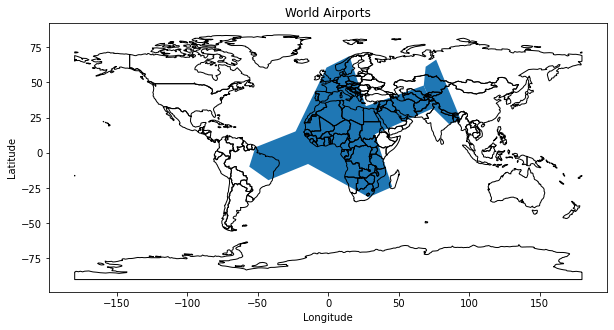

In [5]:
first = airports.loc[first_set] #do this for each set of airports
second = airports.loc[second_set]
third = airports.loc[third_set]

f = list(zip(first.Longitude, first.Latitude))
s = list(zip(second.Longitude, second.Latitude))
t = list(zip(third.Longitude, third.Latitude))

f_poly = Polygon(f).convex_hull #polygons will be their convex hull
s_poly = Polygon(s).convex_hull
t_poly = Polygon(t).convex_hull

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) 

fig,ax = plt.subplots(figsize=(10,7),ncols=1,nrows=1)
base = world.boundary.plot(edgecolor='black', ax=ax, linewidth=1) #this is the background

frame = gpd.GeoDataFrame({'geometry':[f_poly,s_poly,t_poly]}) #plot the polygons
frame.plot(ax=base)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title("World Airports")

## Problem 2
Use the command *geopandas.read_file('county_data.gpkg')* to create a GeoDataFrame of information about US counties.
Each county's shape is stored in the *geometry* column.
Use this to **plot the outlines of all US counties two times**, first using the default CRS and then using EPSG:5071.

Next, create a new GeoDataFrame that combines all counties within a single state.
Drop states with the following STATEFP codes: 02, 15, 60, 66, 69, 72, 78.
Plot this GeoDataFrame to see an outline of the 48 contiguous states.
Ensure a CRS of 5071.

In [6]:
# upload county.gpkg.zip
county = files.upload()
!unzip county_data.gpkg.zip
county_df = gpd.read_file('county_data.gpkg')

Saving county_data.gpkg.zip to county_data.gpkg (4).zip
Archive:  county_data.gpkg.zip
replace county_data.gpkg/county_data.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: county_data.gpkg/county_data.cpg  
replace county_data.gpkg/county_data.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: county_data.gpkg/county_data.dbf  
replace county_data.gpkg/county_data.prj? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: county_data.gpkg/county_data.prj  
replace county_data.gpkg/county_data.shp? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: county_data.gpkg/county_data.shp  
replace county_data.gpkg/county_data.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: county_data.gpkg/county_data.shx  


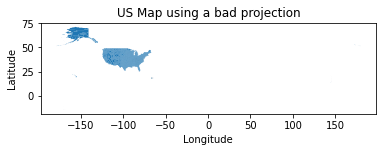

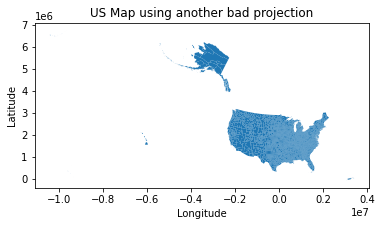

In [7]:
county_df["geometry"].plot()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("US Map using a bad projection")
plt.show()

county_df.to_crs(5071,inplace=True) #change to a different CRS and plot that trash

county_df["geometry"].plot()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("US Map using another bad projection")
plt.show()

Text(27.0, 0.5, 'Latitude')

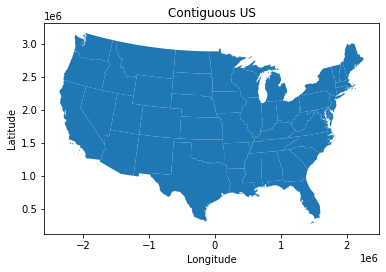

In [8]:
county_df.set_index('STATEFP',drop=True,inplace=True)
county_df.drop(index=['02','15','60','66','69','72','78'],inplace=True) #get rid of the FP codes not in the contiguous US
county_df = county_df.dissolve(by="STATEFP")

ax = county_df.plot()
ax.set_title("Contiguous US")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

## Problem 3

Load in the file *nytimes.csv* as a DataFrame.
This file includes county-level data for the cumulative cases and deaths of Covid-19 in the US, starting with the first case in Snohomish County, Washington, on January 21, 2020.
**First, convert the *date* column into a *DatetimeIndex*.**

Next, use county FIPS codes to **merge your GeoDataFrame from the previous problem with the DataFrame you just created.**
A FIPS code is a 5-digit unique identifier for geographic locations.
For this lab, we will ignore rows in the Covid-19 DataFramw tih unknown FIPS codes.
Also, we will just be examining data from the contiguous US, so **drop all data from Hawaii and Alaska.**

Note that the *fips* column of the Covid-19 DataFrame stores entries as floats, but the county GeoDataFrame stores FIPS codes as strings, with the first two digits in the *STATEFP* column and the last three in the *COUNTYFP* column.

**Plot the cases from March 21, 2020 on top of your state outline map from the previous problem.
Finally, print out the name of the county with the most cases along with its case count.**

In [9]:
nytimes = files.upload()

Saving nytimes.csv to nytimes (2).csv


In [10]:
nytimes = pd.read_csv("nytimes.csv",index_col=0) #load in nytimes dataset into pandas dataframe
nytimes['date'] = pd.to_datetime(nytimes['date'])

data = gpd.read_file('county_data.gpkg')
data['fips'] = (data['STATEFP'] + data['COUNTYFP']).astype(float) #prepare for a merge
data.set_index('STATEFP',drop=True,inplace=True)
data.drop(['02','15','60','66','69','72','78'],inplace=True)

In [11]:
merged = data.merge(nytimes,on='fips') #perform the merge

In [12]:
gdf = gpd.GeoDataFrame(merged[['date','cases','geometry','fips','county']],geometry='geometry') #turn merged data into a geodataframe

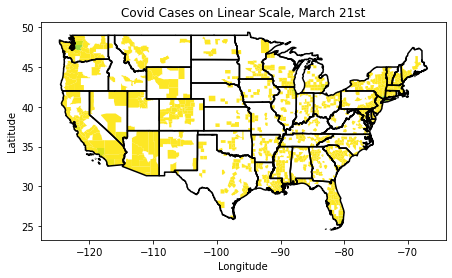

In [13]:
fig, ax = plt.subplots(1, figsize=(10,4))
base = data.dissolve(by='STATEFP').boundary.plot(color='black',ax=ax) #plot contiguous US as background
gdf[gdf['date'] == '2020-03-21'].plot(ax=base,column='cases',cmap="viridis_r") #colormap based on cases
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Covid Cases on Linear Scale, March 21st")
plt.show()

In [14]:
poo = gdf[gdf['date'] == '2020-03-21'] #get the most common county and its number of cases
poo.set_index('county',inplace=True)
idx = poo['cases'].idxmax()
print(idx, poo.loc['New York City']['cases'][0]) 

New York City 6226


## Problem 4

As in Problem 3, plot your state outline map together with a map of Covid-19 cases from March 21, 2020.
This time, use a log scale.
Use EPSG:5071.
Pick a good colormap and be sure to display a colorbar.

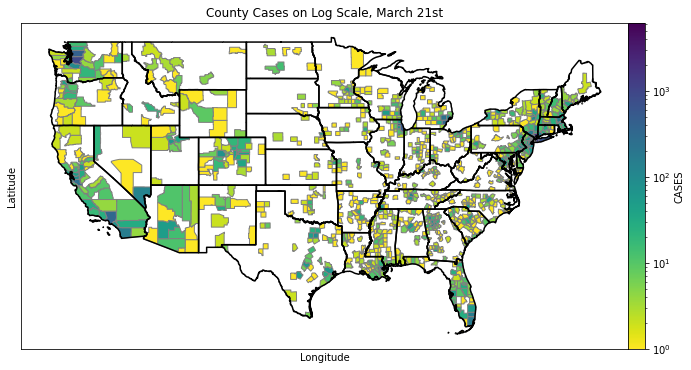

In [15]:
fig, ax = plt.subplots(figsize=(15,6), ncols=1, nrows=1)
base = data.dissolve(by='STATEFP').boundary.plot(color='black',ax=ax)

data = gdf[gdf['date'] == '2020-03-21']['cases']
norm = LogNorm(vmin=min(data),vmax=max(data))

gdf[gdf['date'] == '2020-03-21'].plot(ax=ax, column='cases',cmap='viridis_r',edgecolor='gray',norm=norm) #colormap case counts to each county
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='viridis_r'), ax=ax, orientation='vertical', pad=0, label='CASES') #use norm to build a colorbar

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title('County Cases on Log Scale, March 21st')
ax.set_yticks([])
ax.set_xticks([])
plt.show()

## Problem 5
In this problem, you will create an animation of the spread of Covid-19 through US counties from January 21, 2020 to June 21, 2020.
Use a log scale and a good colormap, and be sure that you're using the same norm and colorbar for the whole animation.
Use EPSG:5071 for the CRS.

As a reminder, below is a summary of what you will need in order to animate this map.
You may also find it helpful to refer to the animation section included with the Volume 4 lab manual. 

- Set up your figure and norm. Be sure to use the highest case count for your vmax so that the scale remains uniform.
- Write your update function. This should plot the cases from a given day.
- Set up your colorbar. Do this outside the update function to avoid adding a new colorbar each day.
- Create the animation. Check to make sure everything displays properly before you save it.
- Save the animation.
- Display the animation.

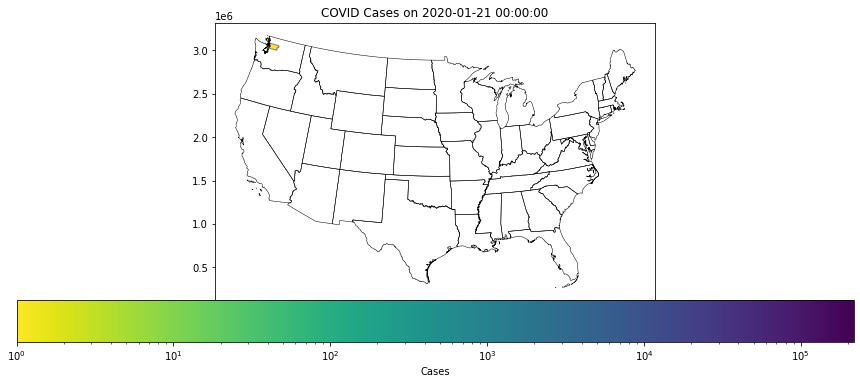

In [16]:
#Set up figure and norm
fig, ax = plt.subplots(figsize=(15,6), ncols=1, nrows=1)

#helper code
data = gpd.read_file('county_data.gpkg')
data['fips'] = (data['STATEFP'] + data['COUNTYFP']).astype(float)
data.set_index('STATEFP',drop=True,inplace=True)
data.drop(['02','15','60','66','69','72','78'],inplace=True)

data.to_crs(5071,inplace=True) #change to the same coordinate reference system

base = data.dissolve(by='STATEFP').boundary.plot(ax=ax,edgecolor="black",linewidth=0.5)

gdf.to_crs(5071,inplace=True)
case_data = gdf['cases']
norm = LogNorm(vmin=min(case_data),vmax=max(case_data))


def update(date):
  #Plot the cases from a single day
  ax.clear()
  base = data.dissolve(by='STATEFP').boundary.plot(ax=ax,edgecolor="black",linewidth=0.5)
  gdf[gdf['date'] == date].plot(ax=base, column='cases',cmap='viridis_r',edgecolor='gray',norm=norm)
  ax.set_title("COVID Cases on {}".format(date))

  
#Set up the colorbar
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='viridis_r'), ax=ax, orientation='horizontal', pad=0, label='Cases')

#Create the animation
plt.ioff()
ani = animation.FuncAnimation(fig, update, frames=pd.date_range('2020-01-21','2020-06-21'), interval=50)
ani.save("prob5.mp4")

In [17]:
HTML(ani.to_html5_video())

<Figure size 432x288 with 0 Axes>